In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

def standarize(data, train_mean, std):
    return (data - train_mean) / std

class RNN:
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

    def initialize(self):
        self.w_x = np.random.randn(self.hidden_dimension, self.input_dimension) * 0.01
        self.w_h = np.random.randn(self.hidden_dimension, self.hidden_dimension) * 0.01
        self.w_y = np.random.randn(self.output_dimension, self.hidden_dimension) * 0.01
        self.b_h = np.zeros((self.hidden_dimension, 1))
        self.b_y = np.zeros((self.output_dimension, 1))

    def step(self, x_t, h_prev):
        h_t = np.tanh(np.dot(self.w_x, x_t) + np.dot(self.w_h, h_prev) + self.b_h)
        y_t = np.dot(self.w_y, h_t) + self.b_y
        return h_t, y_t
    
    def forward_propagation(self, x):
        self.x = x
        self.T = x.shape[0]
        self.h = np.zeros((self.T, self.hidden_dimension))
        self.y_pred = np.zeros((self.T, self.output_dimension))
        h_prev = np.zeros((self.hidden_dimension, 1))

        for t in range(self.T):
            x_t = x[t].reshape(-1, 1)
            h_t, y_t = self.step(x_t, h_prev)
            self.h[t] = h_t.ravel()
            self.y_pred[t] = y_t.ravel()
            h_prev = h_t
        
        return self.y_pred
    
    def back_propagation_through_time(self, y_true, y_pred, learning_rate, clip_value):
        dw_x = np.zeros_like(self.w_x)
        dw_h = np.zeros_like(self.w_h)
        dw_y = np.zeros_like(self.w_y)
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)

        dh_next = np.zeros((self.hidden_dimension, 1))
        dy = mse_derivative(y_true, y_pred)

        for t in reversed(range(self.T)):
            dy_t = dy[t].reshape(-1, 1)
            dw_y += np.dot(dy_t, self.h[t].reshape(1, -1))
            db_y += dy_t
        
            dh = np.dot(self.w_y.T, dy_t) + dh_next
            dh_raw = dh * (1 - self.h[t].reshape(-1, 1) ** 2)
        
            dw_x += np.dot(dh_raw, self.x[t].reshape(1, -1))
            dw_h += np.dot(dh_raw, self.h[t - 1].reshape(1, -1)) if t > 0 else 0
            db_h += dh_raw
        
            dh_next = np.dot(self.w_h.T, dh_raw)

        dw_x *= clip_value
        dw_h *= clip_value
        dw_y *= clip_value
        db_h *= clip_value
        db_y *= clip_value

        self.w_x -= learning_rate * dw_x
        self.w_h -= learning_rate * dw_h
        self.w_y -= learning_rate * dw_y
        self.b_h -= learning_rate * db_h
        self.b_y -= learning_rate * db_y

    def train(self, x, y, epochs, learning_rate, clip_value):
        self.initialize()
        loss_list = []

        for epoch in range(epochs):
            y_pred = self.forward_propagation(x)
            loss = mse(y, y_pred)
            loss_list.append(loss)
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
            self.back_propagation_through_time(y, y_pred, learning_rate, clip_value)
        
        plt.figure(figsize=(10, 6))
        plt.plot(loss_list)
        plt.show()

    def evalutate(self, x):
        y_pred = self.forward_propagation(x)
        return y_pred


In [2]:
file_path = '../../Datasets/조업편차분석.csv'
data = pd.read_csv(file_path)

data['Origin'] = data.index
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(len(shuffled_data) * 0.8)
train_data, test_data = shuffled_data.iloc[:train_size], shuffled_data.iloc[train_size:]

x_train, y_train = train_data.drop(columns=['No.', 'A1', 'Origin'], axis=1), train_data['A1']

x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
y_train_mean = np.mean(y_train, axis=0)
y_train_std = np.std(y_train, axis=0)

x_train = standarize(x_train, x_train_mean, x_train_std).to_numpy()
y_train = standarize(y_train, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

test_data_sorted = test_data.sort_values(by='Origin').reset_index(drop=True)

x_test_sorted, y_test_sorted = test_data_sorted.drop(columns=['No.', 'A1', 'Origin'], axis=1), test_data_sorted['A1']
x_test_sorted = standarize(x_test_sorted, x_train_mean, x_train_std).to_numpy()
y_test_sorted = standarize(y_test_sorted, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

Epoch 100, Loss: 0.3436988361618488
Epoch 200, Loss: 0.06201895081168668
Epoch 300, Loss: 0.035537263396588595
Epoch 400, Loss: 0.027551623316851823
Epoch 500, Loss: 0.024046531701802785


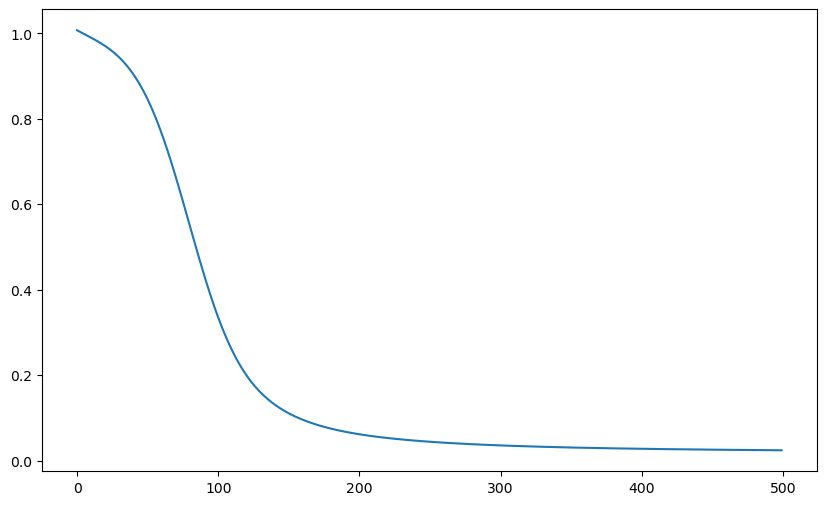

In [3]:
input_dimension = x_train.shape[1]
hidden_dimension = 64
output_dimension = y_train.shape[1]

rnn_model = RNN(
    input_dimension=input_dimension,
    hidden_dimension=hidden_dimension,
    output_dimension=output_dimension
)

rnn_model.train(x_train, y_train, 500, 0.01, 0.5)

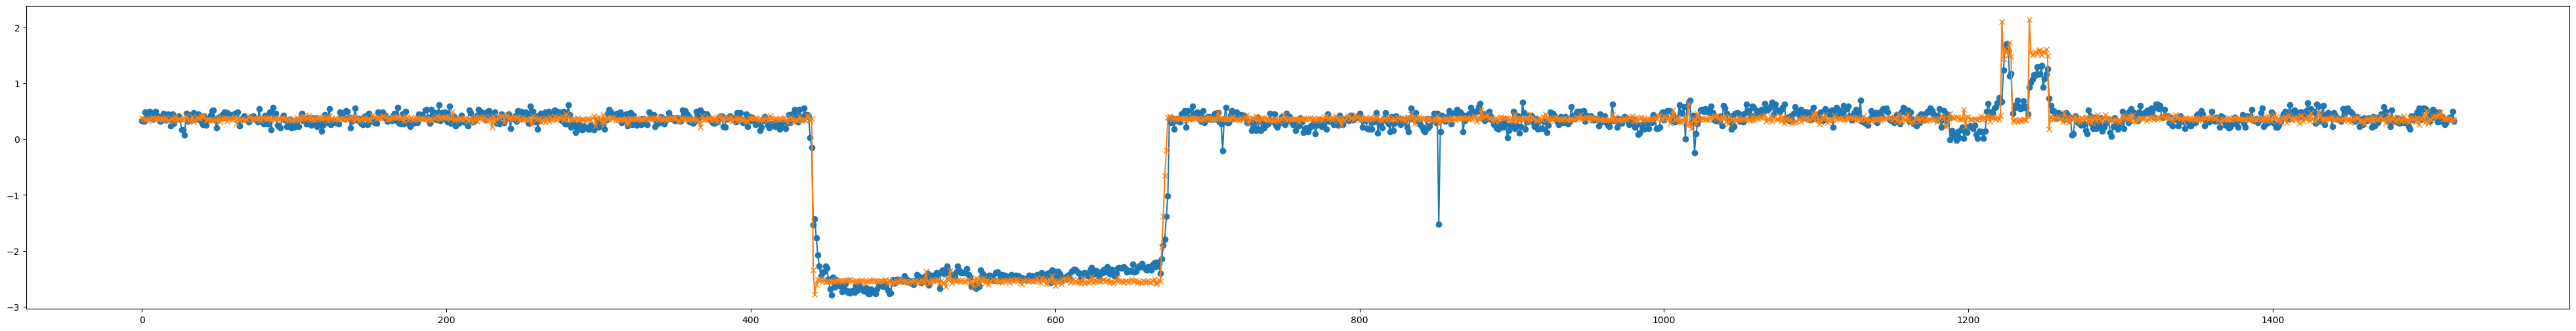

In [ ]:
y_test_pred = rnn_model.evalutate(x_test_sorted, y_test_sorted)

plt.figure(figsize=(50, 6))
plt.plot(y_test_pred, marker="o")
plt.plot(y_test_sorted, marker="x")
plt.show()

In [6]:
def calculate_metrics(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return r2, rmse, mae, mape

calculate_metrics(y_test_sorted, y_test_pred)

(0.9747322119926949,
 0.16807593643848778,
 0.11332147216041058,
 25.498361460794918)